In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import Counter
from scipy import stats



In [5]:
# ============================================
# LOAD DATA & PREPROCESSING
# ============================================
df = pd.read_csv('database.csv')
dftest = df.copy()
dftest = dftest.dropna()

print("="*60)
print("PHÂN TÍCH XÂY DỰNG SMRI (Salinity/Moisture Risk Index)")
print("="*60)
print(f"Số lượng mẫu: {len(dftest)}")

PHÂN TÍCH XÂY DỰNG SMRI (Salinity/Moisture Risk Index)
Số lượng mẫu: 2540035


In [6]:
dftest.columns

Index(['h3_index', 'time', 'month', 'rain_mm', 'solar', 'temp_c', 'temp_max_c',
       'temp_min_c', 'rh_percent', 'caibe_zos', 'cailon_zos', 'cuadai_zos',
       'cuatieu_zos', 'dinhan_zos', 'ganhhao_zos', 'trande_zos', 'pct_tree',
       'pct_shrub', 'pct_grass', 'pct_crop', 'pct_built', 'pct_bare',
       'pct_snow_ice', 'pct_water', 'pct_wetland', 'pct_mangrove',
       'pct_moss_lichen', 'pct_water_river', 'dem_min', 'dem_max', 'dem_mean',
       'slope_min', 'slope_max', 'slope_mean', 'pct_slope_gt_1deg',
       'salinity_min', 'salinity_max', 'salinity_mean', 'salinity_std',
       'pct_salinity_pixels', 'pct_salinity_gte_0_2', 'pct_salinity_gte_0_5',
       'pct_salinity_gte_1_0', 'no_data_land', 'is_sea', 'landcover_label',
       'landcover_label_refined', 'salinity_risk', 'salinity_min_new',
       'salinity_max_new', 'salinity_mean_new', 'salinity_std_new',
       'pct_salinity_pixels_new', 'pct_salinity_gte_0_2_new',
       'pct_salinity_gte_0_5_new', 'pct_salinity_gte_1_0

In [7]:
# ============================================
# BƯỚC 1: Chuẩn hóa dữ liệu về [0,1]
# ============================================
print("\n[BƯỚC 1] Chuẩn hóa dữ liệu về [0,1]")

# QUAN TRỌNG: Lưu từng scaler riêng để tái sử dụng
scalers_dict = {}

# Nhiệt độ
scaler_temp = MinMaxScaler()
temp_norm = scaler_temp.fit_transform(dftest['temp_c'].values.reshape(-1,1)).flatten()
scalers_dict['temp'] = scaler_temp

# Bức xạ mặt trời
scaler_solar = MinMaxScaler()
solar_norm = scaler_solar.fit_transform(dftest['solar'].values.reshape(-1,1)).flatten()
scalers_dict['solar'] = scaler_solar

# Lượng mưa
scaler_rain = MinMaxScaler()
rain_norm = scaler_rain.fit_transform(dftest['rain_mm'].values.reshape(-1,1)).flatten()
scalers_dict['rain'] = scaler_rain

# Độ ẩm
scaler_rh = MinMaxScaler()
rh_norm = scaler_rh.fit_transform(dftest['rh_percent'].values.reshape(-1,1)).flatten()
scalers_dict['rh'] = scaler_rh

# Cao độ
scaler_dem = MinMaxScaler()
dem_norm = scaler_dem.fit_transform(dftest['dem_mean'].values.reshape(-1,1)).flatten()
scalers_dict['dem'] = scaler_dem

scaler_temp_max = MinMaxScaler()
temp_max_norm = scaler_temp_max.fit_transform(dftest['temp_max_c'].values.reshape(-1,1)).flatten()
scalers_dict['temp_max'] = scaler_temp_max

scaler_caibe = MinMaxScaler()
caibe_norm = scaler_caibe.fit_transform(dftest['caibe_zos'].values.reshape(-1,1)).flatten()
scalers_dict['caibe'] = scaler_caibe

scaler_cailon = MinMaxScaler()
cailon_norm = scaler_cailon.fit_transform(dftest['cailon_zos'].values.reshape(-1,1)).flatten()
scalers_dict['cailon'] = scaler_cailon

scaler_cuadai = MinMaxScaler()
cuadai_norm = scaler_cuadai.fit_transform(dftest['cuadai_zos'].values.reshape(-1,1)).flatten()
scalers_dict['cuadai'] = scaler_cuadai

scaler_cuatieu = MinMaxScaler()
cuatieu_norm = scaler_cuatieu.fit_transform(dftest['cuatieu_zos'].values.reshape(-1,1)).flatten()
scalers_dict['cuatieu'] = scaler_cuatieu

scaler_dinhan = MinMaxScaler()
dinhan_norm = scaler_dinhan.fit_transform(dftest['dinhan_zos'].values.reshape(-1,1)).flatten()
scalers_dict['dinhan'] = scaler_dinhan

scaler_ganhhao = MinMaxScaler()
ganhhao_norm = scaler_ganhhao.fit_transform(dftest['ganhhao_zos'].values.reshape(-1,1)).flatten()
scalers_dict['ganhhao'] = scaler_ganhhao

scaler_trande = MinMaxScaler()
trande_norm = scaler_trande.fit_transform(dftest['trande_zos'].values.reshape(-1,1)).flatten()
scalers_dict['trande'] = scaler_trande

scaler_chau_doc = MinMaxScaler()
chau_doc_norm = scaler_chau_doc.fit_transform(dftest['chau_doc_value'].values.reshape(-1,1)).flatten()
scalers_dict['chau_doc'] = scaler_chau_doc

scaler_tan_chau = MinMaxScaler()
tan_chau_norm = scaler_tan_chau.fit_transform(dftest['tan_chau_value'].values.reshape(-1,1)).flatten()
scalers_dict['tan_chau'] = scaler_tan_chau

# Tạo DataFrame với tên biến rõ ràng
X = pd.DataFrame({
    'Nhiệt_độ': temp_norm,
    'Bức_xạ': solar_norm,
    'Mưa': rain_norm,
    'Độ_ẩm': rh_norm,
    'Cao_độ': dem_norm,
    'Nhiệt_độ_max': temp_max_norm,
    'Caibe': caibe_norm,
    'Cailon': cailon_norm,
    'Cuadai': cuadai_norm,
    'Cuatieu': cuatieu_norm,
    'Dinhan': dinhan_norm,
    'Ganhhao': ganhhao_norm,
    'Trande': trande_norm,
    'Chau_doc': chau_doc_norm,
    'Tan_chau': tan_chau_norm
})

y = dftest['salinity_mean'].copy()  # Độ mặn thực đo

print("✅ Đã chuẩn hóa tất cả biến về [0,1]")


[BƯỚC 1] Chuẩn hóa dữ liệu về [0,1]
✅ Đã chuẩn hóa tất cả biến về [0,1]



[BƯỚC 2] Phân tích tương quan

=== Tương quan với Độ mặn ===
Nhiệt_độ       : -0.0183  ÂM (↓ Mặn)
Bức_xạ         : -0.0003  ÂM (↓ Mặn)
Mưa            : +0.0102  DƯƠNG (↑ Mặn)
Độ_ẩm          : -0.0085  ÂM (↓ Mặn)
Cao_độ         : +0.0391  DƯƠNG (↑ Mặn)
Nhiệt_độ_max   : +0.0545  DƯƠNG (↑ Mặn)
Caibe          : -0.0000  ÂM (↓ Mặn)
Cailon         : +0.0000  DƯƠNG (↑ Mặn)
Cuadai         : +0.0000  DƯƠNG (↑ Mặn)
Cuatieu        : +0.0000  DƯƠNG (↑ Mặn)
Dinhan         : +0.0000  DƯƠNG (↑ Mặn)
Ganhhao        : -0.0000  ÂM (↓ Mặn)
Trande         : +0.0000  DƯƠNG (↑ Mặn)
Chau_doc       : -0.0000  ÂM (↓ Mặn)
Tan_chau       : +0.0000  DƯƠNG (↑ Mặn)


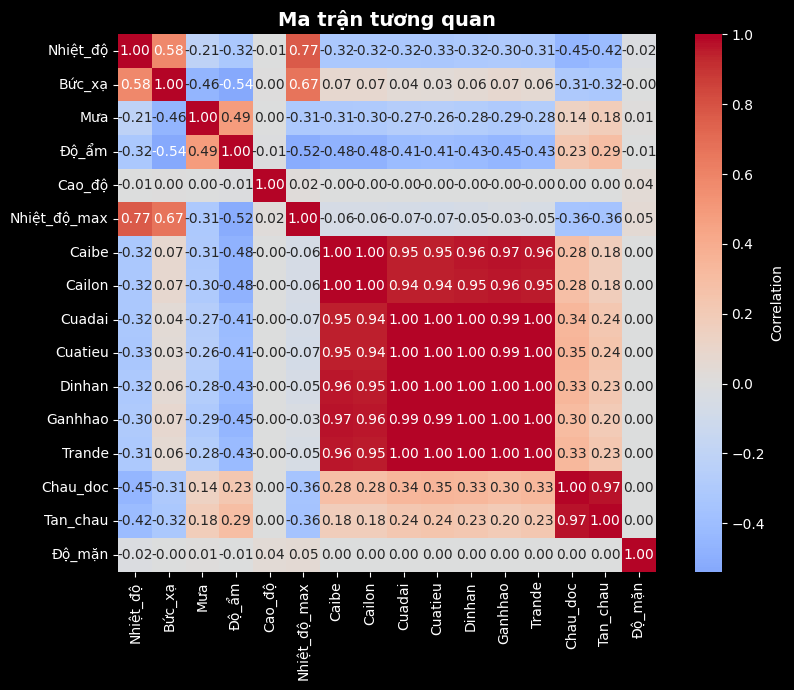


=== Kiểm tra Đa cộng tuyến (VIF) ===
        Biến          VIF
    Nhiệt_độ    54.684121
      Bức_xạ    41.352718
         Mưa     2.148045
       Độ_ẩm    20.665570
      Cao_độ     1.297810
Nhiệt_độ_max    55.628052
       Caibe 21990.313563
      Cailon 17501.530653
      Cuadai 41348.339150
     Cuatieu 44143.299016
      Dinhan 77831.439851
     Ganhhao  5458.250091
      Trande 81866.057130
    Chau_doc    79.875022
    Tan_chau    74.511070
Ghi chú: VIF > 10 → Có đa cộng tuyến nghiêm trọng


In [8]:
# ============================================
# BƯỚC 2: Kiểm tra tương quan
# ============================================
print("\n[BƯỚC 2] Phân tích tương quan")

y_series = pd.Series(y.values, index=X.index, name='Độ_mặn')
corr_with_y = X.corrwith(y_series)

print("\n=== Tương quan với Độ mặn ===")
for var, corr in corr_with_y.items():
    direction = "DƯƠNG (↑ Mặn)" if corr > 0 else "ÂM (↓ Mặn)"
    print(f"{var:15s}: {corr:+.4f}  {direction}")

# Vẽ heatmap
corr_matrix = X.join(y_series).corr()
plt.figure(figsize=(9, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', square=True, cbar_kws={'label': 'Correlation'})
plt.title('Ma trận tương quan', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Kiểm tra VIF (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Biến"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print("\n=== Kiểm tra Đa cộng tuyến (VIF) ===")
print(vif_data.to_string(index=False))
print("Ghi chú: VIF > 10 → Có đa cộng tuyến nghiêm trọng")

In [9]:
# ============================================
# BƯỚC 3: Train MLR/Ridge
# ============================================
print("\n[BƯỚC 3] Huấn luyện mô hình hồi quy")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Chọn model dựa trên VIF
if vif_data['VIF'].max() > 10:
    print("⚠️  Phát hiện đa cộng tuyến! → Sử dụng Ridge Regression")
    model = Ridge(alpha=1.0)
    model_type = 'Ridge'
else:
    print("✅ Không có đa cộng tuyến nghiêm trọng → Sử dụng MLR")
    model = LinearRegression()
    model_type = 'MLR'

# Train model
model.fit(X_train, y_train)

# Lấy hệ số β
β = model.coef_
β0 = model.intercept_

print("\n" + "="*60)
print("HỆ SỐ HỒI QUY β (ĐÂY LÀ KẾT QUẢ CHÍNH!)")
print("="*60)
print(f"β₀ (Intercept): {β0:.6f}")
for i, col in enumerate(X.columns):
    impact = "→ Tăng nguy cơ mặn/hạn" if β[i] > 0 else "→ Giảm nguy cơ mặn/hạn"
    print(f"β{i+1} ({col:12s}): {β[i]:+.6f}  {impact}")


[BƯỚC 3] Huấn luyện mô hình hồi quy
⚠️  Phát hiện đa cộng tuyến! → Sử dụng Ridge Regression

HỆ SỐ HỒI QUY β (ĐÂY LÀ KẾT QUẢ CHÍNH!)
β₀ (Intercept): 0.538107
β1 (Nhiệt_độ    ): -0.145561  → Giảm nguy cơ mặn/hạn
β2 (Bức_xạ      ): -0.018244  → Giảm nguy cơ mặn/hạn
β3 (Mưa         ): +0.011606  → Tăng nguy cơ mặn/hạn
β4 (Độ_ẩm       ): +0.009974  → Tăng nguy cơ mặn/hạn
β5 (Cao_độ      ): +0.142627  → Tăng nguy cơ mặn/hạn
β6 (Nhiệt_độ_max): +0.175240  → Tăng nguy cơ mặn/hạn
β7 (Caibe       ): -0.135927  → Giảm nguy cơ mặn/hạn
β8 (Cailon      ): +0.114458  → Tăng nguy cơ mặn/hạn
β9 (Cuadai      ): -0.266676  → Giảm nguy cơ mặn/hạn
β10 (Cuatieu     ): +0.333239  → Tăng nguy cơ mặn/hạn
β11 (Dinhan      ): +0.040853  → Tăng nguy cơ mặn/hạn
β12 (Ganhhao     ): +0.126946  → Tăng nguy cơ mặn/hạn
β13 (Trande      ): -0.220633  → Giảm nguy cơ mặn/hạn
β14 (Chau_doc    ): -0.013774  → Giảm nguy cơ mặn/hạn
β15 (Tan_chau    ): +0.012333  → Tăng nguy cơ mặn/hạn


In [10]:
# ============================================
# BƯỚC 4: Kiểm tra độ ổn định của β (Cross-validation)
# ============================================
print("\n[BƯỚC 4] Kiểm tra độ ổn định của hệ số β")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
beta_list = []

for train_idx, val_idx in kf.split(X):
    X_fold, y_fold = X.iloc[train_idx], y.iloc[train_idx]
    if model_type == 'Ridge':
        model_fold = Ridge(alpha=1.0)
    else:
        model_fold = LinearRegression()
    model_fold.fit(X_fold, y_fold)
    beta_list.append(model_fold.coef_)

beta_array = np.array(beta_list)

print("\n=== Độ ổn định của β qua 5-fold CV ===")
print(f"{'Biến':15s} {'Mean β':>10s} {'Std β':>10s} {'CV (%)':>10s}")
print("-" * 50)
for i, col in enumerate(X.columns):
    mean_beta = beta_array[:, i].mean()
    std_beta = beta_array[:, i].std()
    cv_pct = (std_beta / abs(mean_beta) * 100) if mean_beta != 0 else 0
    print(f"{col:15s} {mean_beta:+10.4f} {std_beta:10.4f} {cv_pct:10.1f}%")

print("\nGhi chú: CV < 20% là tốt, cho thấy β ổn định")


[BƯỚC 4] Kiểm tra độ ổn định của hệ số β

=== Độ ổn định của β qua 5-fold CV ===
Biến                Mean β      Std β     CV (%)
--------------------------------------------------
Nhiệt_độ           -0.1459     0.0003        0.2%
Bức_xạ             -0.0183     0.0004        2.0%
Mưa                +0.0114     0.0004        3.8%
Độ_ẩm              +0.0095     0.0003        3.0%
Cao_độ             +0.1434     0.0005        0.3%
Nhiệt_độ_max       +0.1746     0.0005        0.3%
Caibe              -0.1457     0.0108        7.4%
Cailon             +0.1235     0.0099        8.0%
Cuadai             -0.2632     0.0105        4.0%
Cuatieu            +0.3257     0.0105        3.2%
Dinhan             +0.0201     0.0155       77.1%
Ganhhao            +0.1247     0.0032        2.5%
Trande             -0.1933     0.0162        8.4%
Chau_doc           -0.0132     0.0006        4.3%
Tan_chau           +0.0116     0.0007        5.7%

Ghi chú: CV < 20% là tốt, cho thấy β ổn định



[BƯỚC 5] Đánh giá hiệu suất mô hình

=== Hiệu suất trên tập Train ===
R²:   0.0158
RMSE: 0.1016
MAE:  0.0700

=== Hiệu suất trên tập Test ===
R²:   0.0156
RMSE: 0.1016
MAE:  0.0700


C:\Users\MY PC\AppData\Local\Temp\ipykernel_2276\1009776245.py:49: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\MY PC\AppData\Local\Temp\ipykernel_2276\1009776245.py:50: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('mlr_validation.png', dpi=300, bbox_inches='tight')
C:\Users\MY PC\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


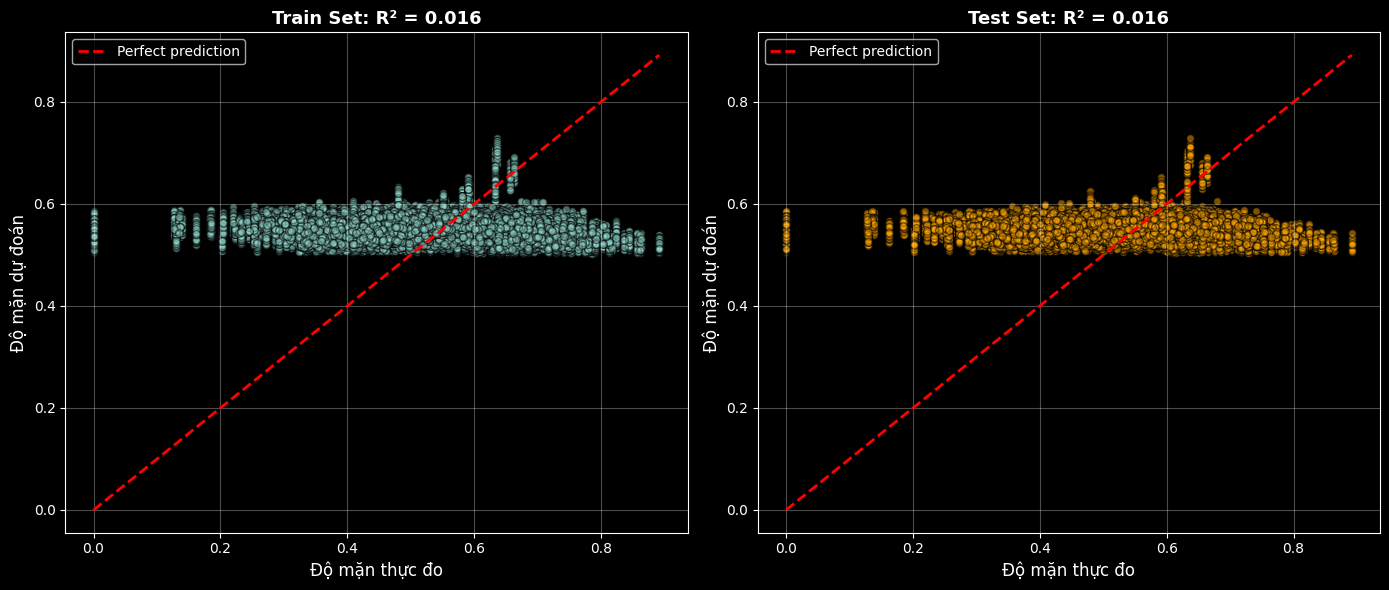

In [11]:
# ============================================
# BƯỚC 5: Đánh giá model
# ============================================
print("\n[BƯỚC 5] Đánh giá hiệu suất mô hình")

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("\n=== Hiệu suất trên tập Train ===")
print(f"R²:   {r2_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")
print(f"MAE:  {mean_absolute_error(y_train, y_pred_train):.4f}")

print("\n=== Hiệu suất trên tập Test ===")
print(f"R²:   {r2_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE:  {mean_absolute_error(y_test, y_pred_test):.4f}")

# Scatter plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Train set
axes[0].scatter(y_train, y_pred_train, alpha=0.5, edgecolors='k', s=30)
axes[0].plot([y_train.min(), y_train.max()],
             [y_train.min(), y_train.max()],
             'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('Độ mặn thực đo', fontsize=12)
axes[0].set_ylabel('Độ mặn dự đoán', fontsize=12)
axes[0].set_title(f'Train Set: R² = {r2_train:.3f}', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test set
axes[1].scatter(y_test, y_pred_test, alpha=0.5, edgecolors='k', s=30, color='orange')
axes[1].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect prediction')
axes[1].set_xlabel('Độ mặn thực đo', fontsize=12)
axes[1].set_ylabel('Độ mặn dự đoán', fontsize=12)
axes[1].set_title(f'Test Set: R² = {r2_test:.3f}', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('mlr_validation.png', dpi=300, bbox_inches='tight')
plt.show()


[BƯỚC 6] Phân tích residuals

Kiểm tra phân phối chuẩn (p-value): 0.0000
⚠️  Residuals không phân phối chuẩn hoàn toàn


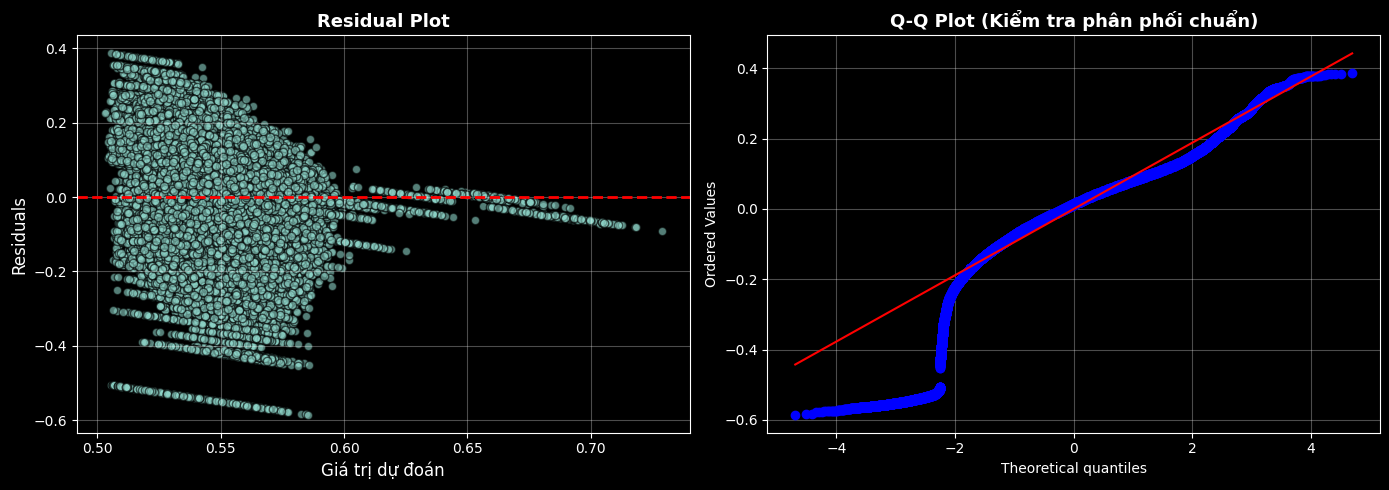

In [12]:
# ============================================
# BƯỚC 6: Kiểm tra residuals
# ============================================
print("\n[BƯỚC 6] Phân tích residuals")

residuals = y_test - y_pred_test

# Test normality
_, p_value_normality = stats.normaltest(residuals)
print(f"\nKiểm tra phân phối chuẩn (p-value): {p_value_normality:.4f}")
if p_value_normality > 0.05:
    print("✅ Residuals có phân phối chuẩn")
else:
    print("⚠️  Residuals không phân phối chuẩn hoàn toàn")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residual plot
axes[0].scatter(y_pred_test, residuals, alpha=0.6, edgecolors='k')
axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Giá trị dự đoán', fontsize=12)
axes[0].set_ylabel('Residuals', fontsize=12)
axes[0].set_title('Residual Plot', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Kiểm tra phân phối chuẩn)', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


[BƯỚC 7] Tính toán SMRI

=== Thống kê SMRI ===
SMRI (raw):
  Min:  0.5026
  Max:  0.7295
  Mean: 0.5514
  Std:  0.0129

SMRI (chuẩn hóa [0,1]):
  Min:  0.0000
  Max:  1.0000
  Mean: 0.2148
  Std:  0.0567


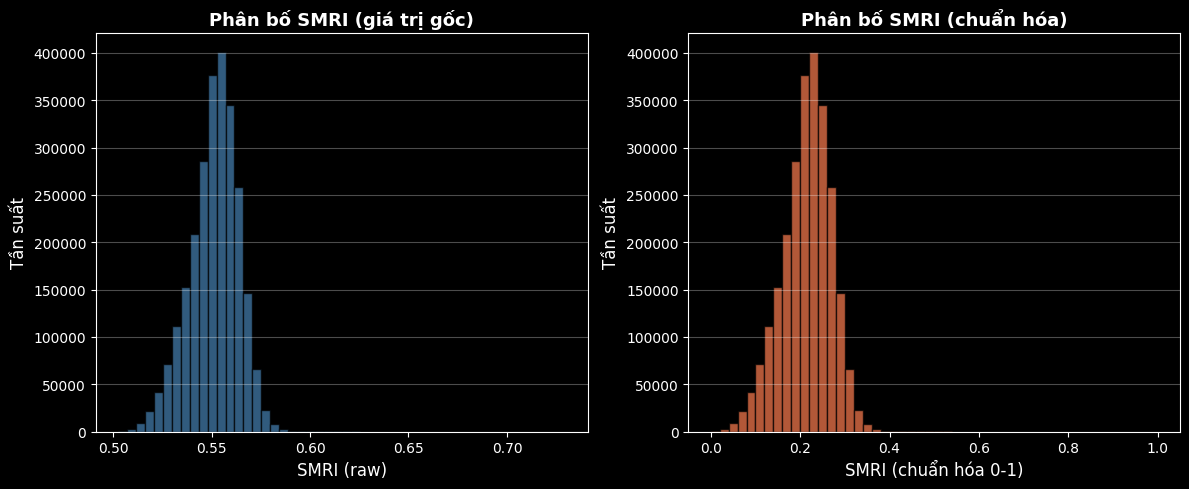

In [13]:
# ============================================
# BƯỚC 7: Tính SMRI cho toàn bộ dữ liệu
# ============================================
print("\n[BƯỚC 7] Tính toán SMRI")

SMRI = model.predict(X)

# Chuẩn hóa SMRI về [0,1]
SMRI_min = SMRI.min()
SMRI_max = SMRI.max()
SMRI_norm = (SMRI - SMRI_min) / (SMRI_max - SMRI_min)

print("\n=== Thống kê SMRI ===")
print(f"SMRI (raw):")
print(f"  Min:  {SMRI_min:.4f}")
print(f"  Max:  {SMRI_max:.4f}")
print(f"  Mean: {SMRI.mean():.4f}")
print(f"  Std:  {SMRI.std():.4f}")
print(f"\nSMRI (chuẩn hóa [0,1]):")
print(f"  Min:  {SMRI_norm.min():.4f}")
print(f"  Max:  {SMRI_norm.max():.4f}")
print(f"  Mean: {SMRI_norm.mean():.4f}")
print(f"  Std:  {SMRI_norm.std():.4f}")

# Histogram
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(SMRI, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('SMRI (raw)', fontsize=12)
plt.ylabel('Tần suất', fontsize=12)
plt.title('Phân bố SMRI (giá trị gốc)', fontsize=13, fontweight='bold')
plt.grid(alpha=0.3, axis='y')

plt.subplot(1, 2, 2)
plt.hist(SMRI_norm, bins=50, edgecolor='black', alpha=0.7, color='coral')
plt.xlabel('SMRI (chuẩn hóa 0-1)', fontsize=12)
plt.ylabel('Tần suất', fontsize=12)
plt.title('Phân bố SMRI (chuẩn hóa)', fontsize=13, fontweight='bold')
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('smri_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# ============================================
# BƯỚC 8: Phân loại mức độ nguy cơ
# ============================================
print("\n[BƯỚC 8] Phân loại mức độ nguy cơ")

# Dùng quantile để phân chia
low_threshold = np.quantile(SMRI_norm, 0.33)
high_threshold = np.quantile(SMRI_norm, 0.67)

print(f"\n=== Ngưỡng phân loại ===")
print(f"Thấp:        SMRI < {low_threshold:.4f}")
print(f"Trung bình:  {low_threshold:.4f} ≤ SMRI < {high_threshold:.4f}")
print(f"Cao:         SMRI ≥ {high_threshold:.4f}")

def classify_risk(smri):
    if smri < low_threshold:
        return 'Thấp'
    elif smri < high_threshold:
        return 'Trung bình'
    else:
        return 'Cao'

risk_class = [classify_risk(s) for s in SMRI_norm]

print("\n=== Phân bố mức độ nguy cơ ===")
risk_counts = Counter(risk_class)
for level in ['Thấp', 'Trung bình', 'Cao']:
    count = risk_counts[level]
    pct = count / len(risk_class) * 100
    print(f"{level:15s}: {count:5d} mẫu ({pct:5.1f}%)")


[BƯỚC 8] Phân loại mức độ nguy cơ

=== Ngưỡng phân loại ===
Thấp:        SMRI < 0.1956
Trung bình:  0.1956 ≤ SMRI < 0.2409
Cao:         SMRI ≥ 0.2409

=== Phân bố mức độ nguy cơ ===
Thấp           : 838212 mẫu ( 33.0%)
Trung bình     : 863611 mẫu ( 34.0%)
Cao            : 838212 mẫu ( 33.0%)



[BƯỚC 9] Phân tích mức độ quan trọng các biến

=== Độ quan trọng các biến ===
        Biến         β  Độ_quan_trọng_%
     Cuatieu  0.333239        18.847391
      Cuadai -0.266676        15.082705
      Trande -0.220633        12.478598
Nhiệt_độ_max  0.175240         9.911262
    Nhiệt_độ -0.145561         8.232637
      Cao_độ  0.142627         8.066701
       Caibe -0.135927         7.687771
     Ganhhao  0.126946         7.179844
      Cailon  0.114458         6.473541
      Dinhan  0.040853         2.310565
      Bức_xạ -0.018244         1.031866
    Chau_doc -0.013774         0.779038
    Tan_chau  0.012333         0.697559
         Mưa  0.011606         0.656418
       Độ_ẩm  0.009974         0.564104


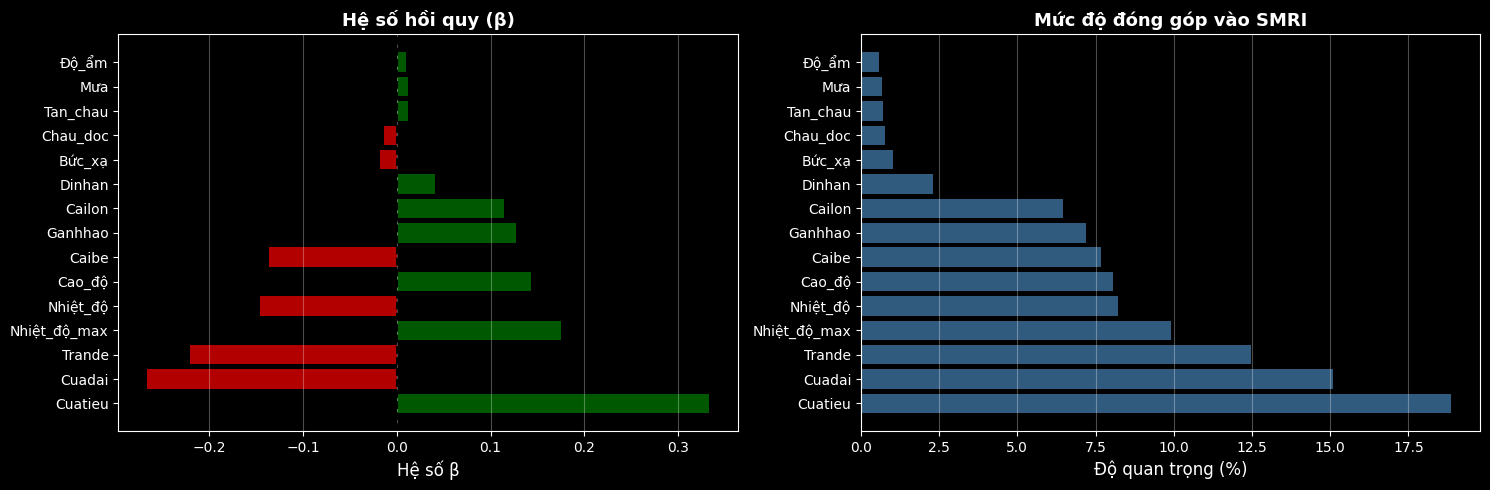

In [15]:
# ============================================
# BƯỚC 9: Feature Importance
# ============================================
print("\n[BƯỚC 9] Phân tích mức độ quan trọng các biến")

abs_beta = np.abs(β)
importance = abs_beta / abs_beta.sum() * 100

importance_df = pd.DataFrame({
    'Biến': X.columns,
    'β': β,
    'Độ_quan_trọng_%': importance
}).sort_values('Độ_quan_trọng_%', ascending=False)

print("\n=== Độ quan trọng các biến ===")
print(importance_df.to_string(index=False))

# Biểu đồ
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Subplot 1: Hệ số β
colors = ['red' if x < 0 else 'green' for x in importance_df['β']]
axes[0].barh(importance_df['Biến'], importance_df['β'], color=colors, alpha=0.7)
axes[0].axvline(0, color='black', linestyle='--', linewidth=1.5)
axes[0].set_xlabel('Hệ số β', fontsize=12)
axes[0].set_title('Hệ số hồi quy (β)', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3, axis='x')

# Subplot 2: Độ quan trọng
axes[1].barh(importance_df['Biến'], importance_df['Độ_quan_trọng_%'],
             color='steelblue', alpha=0.7)
axes[1].set_xlabel('Độ quan trọng (%)', fontsize=12)
axes[1].set_title('Mức độ đóng góp vào SMRI', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# ============================================
# BƯỚC 10: LƯU CÁC HỆ SỐ VÀ THAM SỐ
# ============================================
print("\n[BƯỚC 10] Lưu các hệ số và tham số")

# 1. Lưu scalers
with open('smri_scalers.pkl', 'wb') as f:
    pickle.dump(scalers_dict, f)
print("✅ Đã lưu scalers → smri_scalers.pkl")

# 2. Lưu model
with open('smri_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("✅ Đã lưu model → smri_model.pkl")

# 3. Lưu thresholds
thresholds = {
    'smri_min': SMRI_min,
    'smri_max': SMRI_max,
    'low_threshold': low_threshold,
    'high_threshold': high_threshold
}
with open('smri_thresholds.pkl', 'wb') as f:
    pickle.dump(thresholds, f)
print("✅ Đã lưu thresholds → smri_thresholds.pkl")

# 4. Lưu coefficients dạng text
coefficients_info = {
    'model_type': model_type,
    'intercept': β0,
    'coefficients': dict(zip(X.columns, β)),
    'feature_importance': importance_df.to_dict('records'),
    'performance': {
        'R2_train': r2_train,
        'R2_test': r2_test,
        'RMSE_train': rmse_train,
        'RMSE_test': rmse_test
    }
}
with open('smri_coefficients.pkl', 'wb') as f:
    pickle.dump(coefficients_info, f)
print("✅ Đã lưu coefficients → smri_coefficients.pkl")

# 5. Export công thức dạng text
with open('smri_formula.txt', 'w', encoding='utf-8') as f:
    f.write("=" * 80 + "\n")
    f.write("CÔNG THỨC TÍNH SMRI (Salinity/Moisture Risk Index)\n")
    f.write("=" * 80 + "\n\n")
    
    f.write("BƯỚC 1: Chuẩn hóa các biến về [0,1]\n")
    f.write("-" * 80 + "\n")
    var_mapping = {
        
        'Nhiệt_độ': 'temp_c',
        'Bức_xạ': 'solar',
        'Mưa': 'rain_mm',
        'Độ_ẩm': 'rh_percent',
        'Cao_độ': 'dem_mean',
        'Nhiệt_độ_max': 'temp_max_c',
        'Caibe': 'caibe_zos',
        'Cailon': 'cailon_zos',
        'Cuadai': 'cuadai_zos',
        'Cuatieu': 'cuatieu_zos',
        'Dinhan': 'dinhan_zos',
        'Ganhhao': 'ganhhao_zos',
        'Trande': 'trande_zos',
        'Chau_doc': 'chau_doc_value',
        'Tan_chau': 'tan_chau_value'
    }
    for display_name, original_name in var_mapping.items():
        var_min = dftest[original_name].min()
        var_max = dftest[original_name].max()
        f.write(f"{display_name}_norm = ({original_name} - {var_min:.4f}) / ({var_max:.4f} - {var_min:.4f})\n")
    
    f.write("\n" + "BƯỚC 2: Tính SMRI (raw)\n")
    f.write("-" * 80 + "\n")
    f.write(f"SMRI = {β0:.6f}\n")
    for col, coef in zip(X.columns, β):
        f.write(f"     {coef:+.6f} × {col}_norm\n")
    
    f.write("\n" + "BƯỚC 3: Chuẩn hóa SMRI về [0,1]\n")
    f.write("-" * 80 + "\n")
    f.write(f"SMRI_norm = (SMRI - {SMRI_min:.6f}) / ({SMRI_max:.6f} - {SMRI_min:.6f})\n")
    
    f.write("\n" + "BƯỚC 4: Phân loại nguy cơ\n")
    f.write("-" * 80 + "\n")
    f.write(f"Nguy cơ Thấp:        SMRI_norm < {low_threshold:.4f}\n")
    f.write(f"Nguy cơ Trung bình:  {low_threshold:.4f} ≤ SMRI_norm < {high_threshold:.4f}\n")
    f.write(f"Nguy cơ Cao:         SMRI_norm ≥ {high_threshold:.4f}\n")
    
    f.write("\n" + "MỨC ĐỘ QUAN TRỌNG CÁC BIẾN\n")
    f.write("-" * 80 + "\n")
    for _, row in importance_df.iterrows():
        f.write(f"{row['Biến']:15s}: {row['Độ_quan_trọng_%']:6.2f}% (β = {row['β']:+.6f})\n")
    
    f.write("\n" + "HIỆU SUẤT MÔ HÌNH\n")
    f.write("-" * 80 + "\n")
    f.write(f"Model type: {model_type}\n")
    f.write(f"R² (test):  {r2_test:.4f}\n")
    f.write(f"RMSE (test): {rmse_test:.4f}\n")

print("✅ Đã xuất công thức → smri_formula.txt")

# 6. Lưu kết quả vào CSV
dftest['SMRI_raw'] = SMRI
dftest['SMRI_norm'] = SMRI_norm
dftest['Risk_Level'] = risk_class

output_df = dftest[['temp_c', 'solar', 'rain_mm', 
                     'rh_percent', 'dem_mean', 'temp_max_c', 'caibe_zos', 'cailon_zos', 'cuadai_zos', 'cuatieu_zos', 'dinhan_zos', 'ganhhao_zos', 'trande_zos','salinity_mean',
                     'SMRI_raw', 'SMRI_norm', 'Risk_Level']]
output_df.to_csv('output_with_SMRI.csv', index=False)
print("✅ Đã lưu kết quả → output_with_SMRI.csv")



[BƯỚC 10] Lưu các hệ số và tham số
✅ Đã lưu scalers → smri_scalers.pkl
✅ Đã lưu model → smri_model.pkl
✅ Đã lưu thresholds → smri_thresholds.pkl
✅ Đã lưu coefficients → smri_coefficients.pkl
✅ Đã xuất công thức → smri_formula.txt
✅ Đã lưu kết quả → output_with_SMRI.csv


In [21]:



# ============================================
# BƯỚC 11: Tạo hàm tính SMRI cho dữ liệu mới
# ============================================
print("\n[BƯỚC 11] Tạo hàm tính SMRI cho dữ liệu mới")

def calculate_smri_for_new_data(new_data):
    """
    Tính SMRI cho dữ liệu mới
    
    Parameters:
    -----------
    new_data : dict
        Dictionary chứa các giá trị:
        {
            'temp_dry_mean_dry': float,
            'solar_sum_mua_kho': float,
            'rain_dry_sum': float,
            'mua_kho': float,
            'dem_mean': float
        }
    
    Returns:
    --------
    dict: {
        'SMRI_raw': float,
        'SMRI_norm': float (0-1),
        'Risk_Level': str ('Thấp', 'Trung bình', 'Cao')
    }
    """
    # Load các tham số đã lưu
    with open('smri_scalers.pkl', 'rb') as f:
        scalers = pickle.load(f)
    with open('smri_model.pkl', 'rb') as f:
        model = pickle.load(f)
    with open('smri_thresholds.pkl', 'rb') as f:
        thresh = pickle.load(f)
    
    # Chuẩn hóa từng biến
    X_new = pd.DataFrame({
        'Nhiệt_độ': scalers['temp'].transform([[new_data['temp_dry_mean_dry']]])[0][0],
        'Bức_xạ': scalers['solar'].transform([[new_data['solar_sum_mua_kho']]])[0][0],
        'Mưa': scalers['rain'].transform([[new_data['rain_dry_sum']]])[0][0],
        'Độ_ẩm': scalers['rh'].transform([[new_data['mua_kho']]])[0][0],
        'Cao_độ': scalers['dem'].transform([[new_data['dem_mean']]])[0][0],
        'Nhiệt_độ_max': scalers['temp_max'].transform([[new_data['temp_max_c']]])[0][0],
        'Caibe': scalers['caibe'].transform([[new_data['caibe_zos']]])[0][0],
        'Cailon': scalers['cailon'].transform([[new_data['cailon_zos']]])[0][0],
        'Cuadai': scalers['cuadai'].transform([[new_data['cuadai_zos']]])[0][0],
        'Cuatieu': scalers['cuatieu'].transform([[new_data['cuatieu_zos']]])[0][0],
        'Dinhan': scalers['dinhan'].transform([[new_data['dinhan_zos']]])[0][0],
        'Ganhhao': scalers['ganhhao'].transform([[new_data['ganhhao_zos']]])[0][0],
        'Trande': scalers['trande'].transform([[new_data['trande_zos']]])[0][0],
        'Chau_doc': scalers['chau_doc'].transform([[new_data['chau_doc_value']]])[0][0],
        'Tan_chau': scalers['tan_chau'].transform([[new_data['tan_chau_value']]])[0][0],
    }, index=[0])
    
    # Tính SMRI
    smri_raw = model.predict(X_new)[0]
    
    # Chuẩn hóa về [0,1]
    smri_norm = (smri_raw - thresh['smri_min']) / (thresh['smri_max'] - thresh['smri_min'])
    smri_norm = np.clip(smri_norm, 0, 1)  # Đảm bảo trong khoảng [0,1]
    
    # Phân loại
    if smri_norm < thresh['low_threshold']:
        risk = 'Thấp'
    elif smri_norm < thresh['high_threshold']:
        risk = 'Trung bình'
    else:
        risk = 'Cao'
    
    return {
        'SMRI_raw': smri_raw,
        'SMRI_norm': smri_norm,
        'Risk_Level': risk
    }

# Lưu hàm này vào file
with open('calculate_smri.py', 'w', encoding='utf-8') as f:
    f.write('''import pickle
import pandas as pd
import numpy as np

def calculate_smri(new_data):
    """
    Tính SMRI cho dữ liệu mới
    
    Parameters:
    -----------
    new_data : dict
        {'temp_dry_mean_dry': value, 'solar_sum_mua_kho': value, 
         'rain_dry_sum': value, 'mua_kho': value, 'dem_mean': value}
    
    Returns:
    --------
    dict: {'SMRI_raw': float, 'SMRI_norm': float, 'Risk_Level': str}
    """
    # Load parameters
    with open('smri_scalers.pkl', 'rb') as f:
        scalers = pickle.load(f)
    with open('smri_model.pkl', 'rb') as f:
        model = pickle.load(f)
    with open('smri_thresholds.pkl', 'rb') as f:
        thresh = pickle.load(f)
    
    # Normalize
    X_new = pd.DataFrame({
        'Nhiệt_độ': scalers['temp'].transform([[new_data['temp_dry_mean_dry']]])[0][0],
        'Bức_xạ': scalers['solar'].transform([[new_data['solar_sum_mua_kho']]])[0][0],
        'Mưa': scalers['rain'].transform([[new_data['rain_dry_sum']]])[0][0],
        'Độ_ẩm': scalers['rh'].transform([[new_data['mua_kho']]])[0][0],
        'Cao_độ': scalers['dem'].transform([[new_data['dem_mean']]])[0][0],
    }, index=[0])
    
    # Calculate SMRI
    smri_raw = model.predict(X_new)[0]
    smri_norm = (smri_raw - thresh['smri_min']) / (thresh['smri_max'] - thresh['smri_min'])
    smri_norm = np.clip(smri_norm, 0, 1)
    
    # Classify
    if smri_norm < thresh['low_threshold']:
        risk = 'Thấp'
    elif smri_norm < thresh['high_threshold']:
        risk = 'Trung bình'
    else:
        risk = 'Cao'
    
    return {
        'SMRI_raw': smri_raw,
        'SMRI_norm': smri_norm,
        'Risk_Level': risk
    }

# Ví dụ sử dụng:
if __name__ == "__main__":
    example_data = {
        'temp_dry_mean_dry': 32.5,
        'solar_sum_mua_kho': 250,
        'rain_dry_sum': 10,
        'mua_kho': 65,
        'dem_mean': 15
    }
    result = calculate_smri(example_data)
    print(f"SMRI = {result['SMRI_norm']:.4f} → Nguy cơ: {result['Risk_Level']}")
''')

print("✅ Đã tạo file calculate_smri.py để sử dụng cho dữ liệu mới")

# Test hàm với 1 ví dụ





[BƯỚC 11] Tạo hàm tính SMRI cho dữ liệu mới
✅ Đã tạo file calculate_smri.py để sử dụng cho dữ liệu mới


In [ ]:
# ============================================
# TÓM TẮT CUỐI CÙNG
# ============================================
print("\n" + "="*80)
print("🎉 HOÀN THÀNH! TÓM TẮT KẾT QUẢ")
print("="*80)
print(f"\n📊 Mô hình: {model_type}")
print(f"📈 R² (test): {r2_test:.4f}")
print(f"📉 RMSE (test): {rmse_test:.4f}")
print(f"🎯 Biến quan trọng nhất: {importance_df.iloc[0]['Biến']} ({importance_df.iloc[0]['Độ_quan_trọng_%']:.1f}%)")

print("\n📁 Các file đã tạo:")
print("  1. smri_scalers.pkl        - Các scaler để chuẩn hóa")
print("  2. smri_model.pkl          - Mô hình đã train")
print("  3. smri_thresholds.pkl     - Ngưỡng phân loại")
print("  4. smri_coefficients.pkl   - Hệ số β và thông tin")
print("  5. smri_formula.txt        - Công thức SMRI dạng text")
print("  6. output_with_SMRI.csv    - Dữ liệu kèm SMRI")
print("  7. calculate_smri.py       - Hàm tính SMRI cho dữ liệu mới")
print("  8. *.png                   - Các biểu đồ phân tích")

print("\n💡 Cách sử dụng cho dữ liệu mới:")
print("  from calculate_smri import calculate_smri")
print("  new_data = {'temp_dry_mean_dry': 32, 'solar_sum_mua_kho': 250, ...}")
print("  result = calculate_smri(new_data)")
print("  print(result['SMRI_norm'], result['Risk_Level'])")

print("\n" + "="*80)


🎉 HOÀN THÀNH! TÓM TẮT KẾT QUẢ

📊 Mô hình: Ridge
📈 R² (test): 0.0286
📉 RMSE (test): 0.0786
🎯 Biến quan trọng nhất: Nhiệt_độ (49.9%)

📁 Các file đã tạo:
  1. smri_scalers.pkl        - Các scaler để chuẩn hóa
  2. smri_model.pkl          - Mô hình đã train
  3. smri_thresholds.pkl     - Ngưỡng phân loại
  4. smri_coefficients.pkl   - Hệ số β và thông tin
  5. smri_formula.txt        - Công thức SMRI dạng text
  6. output_with_SMRI.csv    - Dữ liệu kèm SMRI
  7. calculate_smri.py       - Hàm tính SMRI cho dữ liệu mới
  8. *.png                   - Các biểu đồ phân tích

💡 Cách sử dụng cho dữ liệu mới:
  from calculate_smri import calculate_smri
  new_data = {'temp_dry_mean_dry': 32, 'solar_sum_mua_kho': 250, ...}
  result = calculate_smri(new_data)
  print(result['SMRI_norm'], result['Risk_Level'])

